
 
 Rule Adam 512 2048 0.0003 0.04828406050227636 0.9836702066917894 1


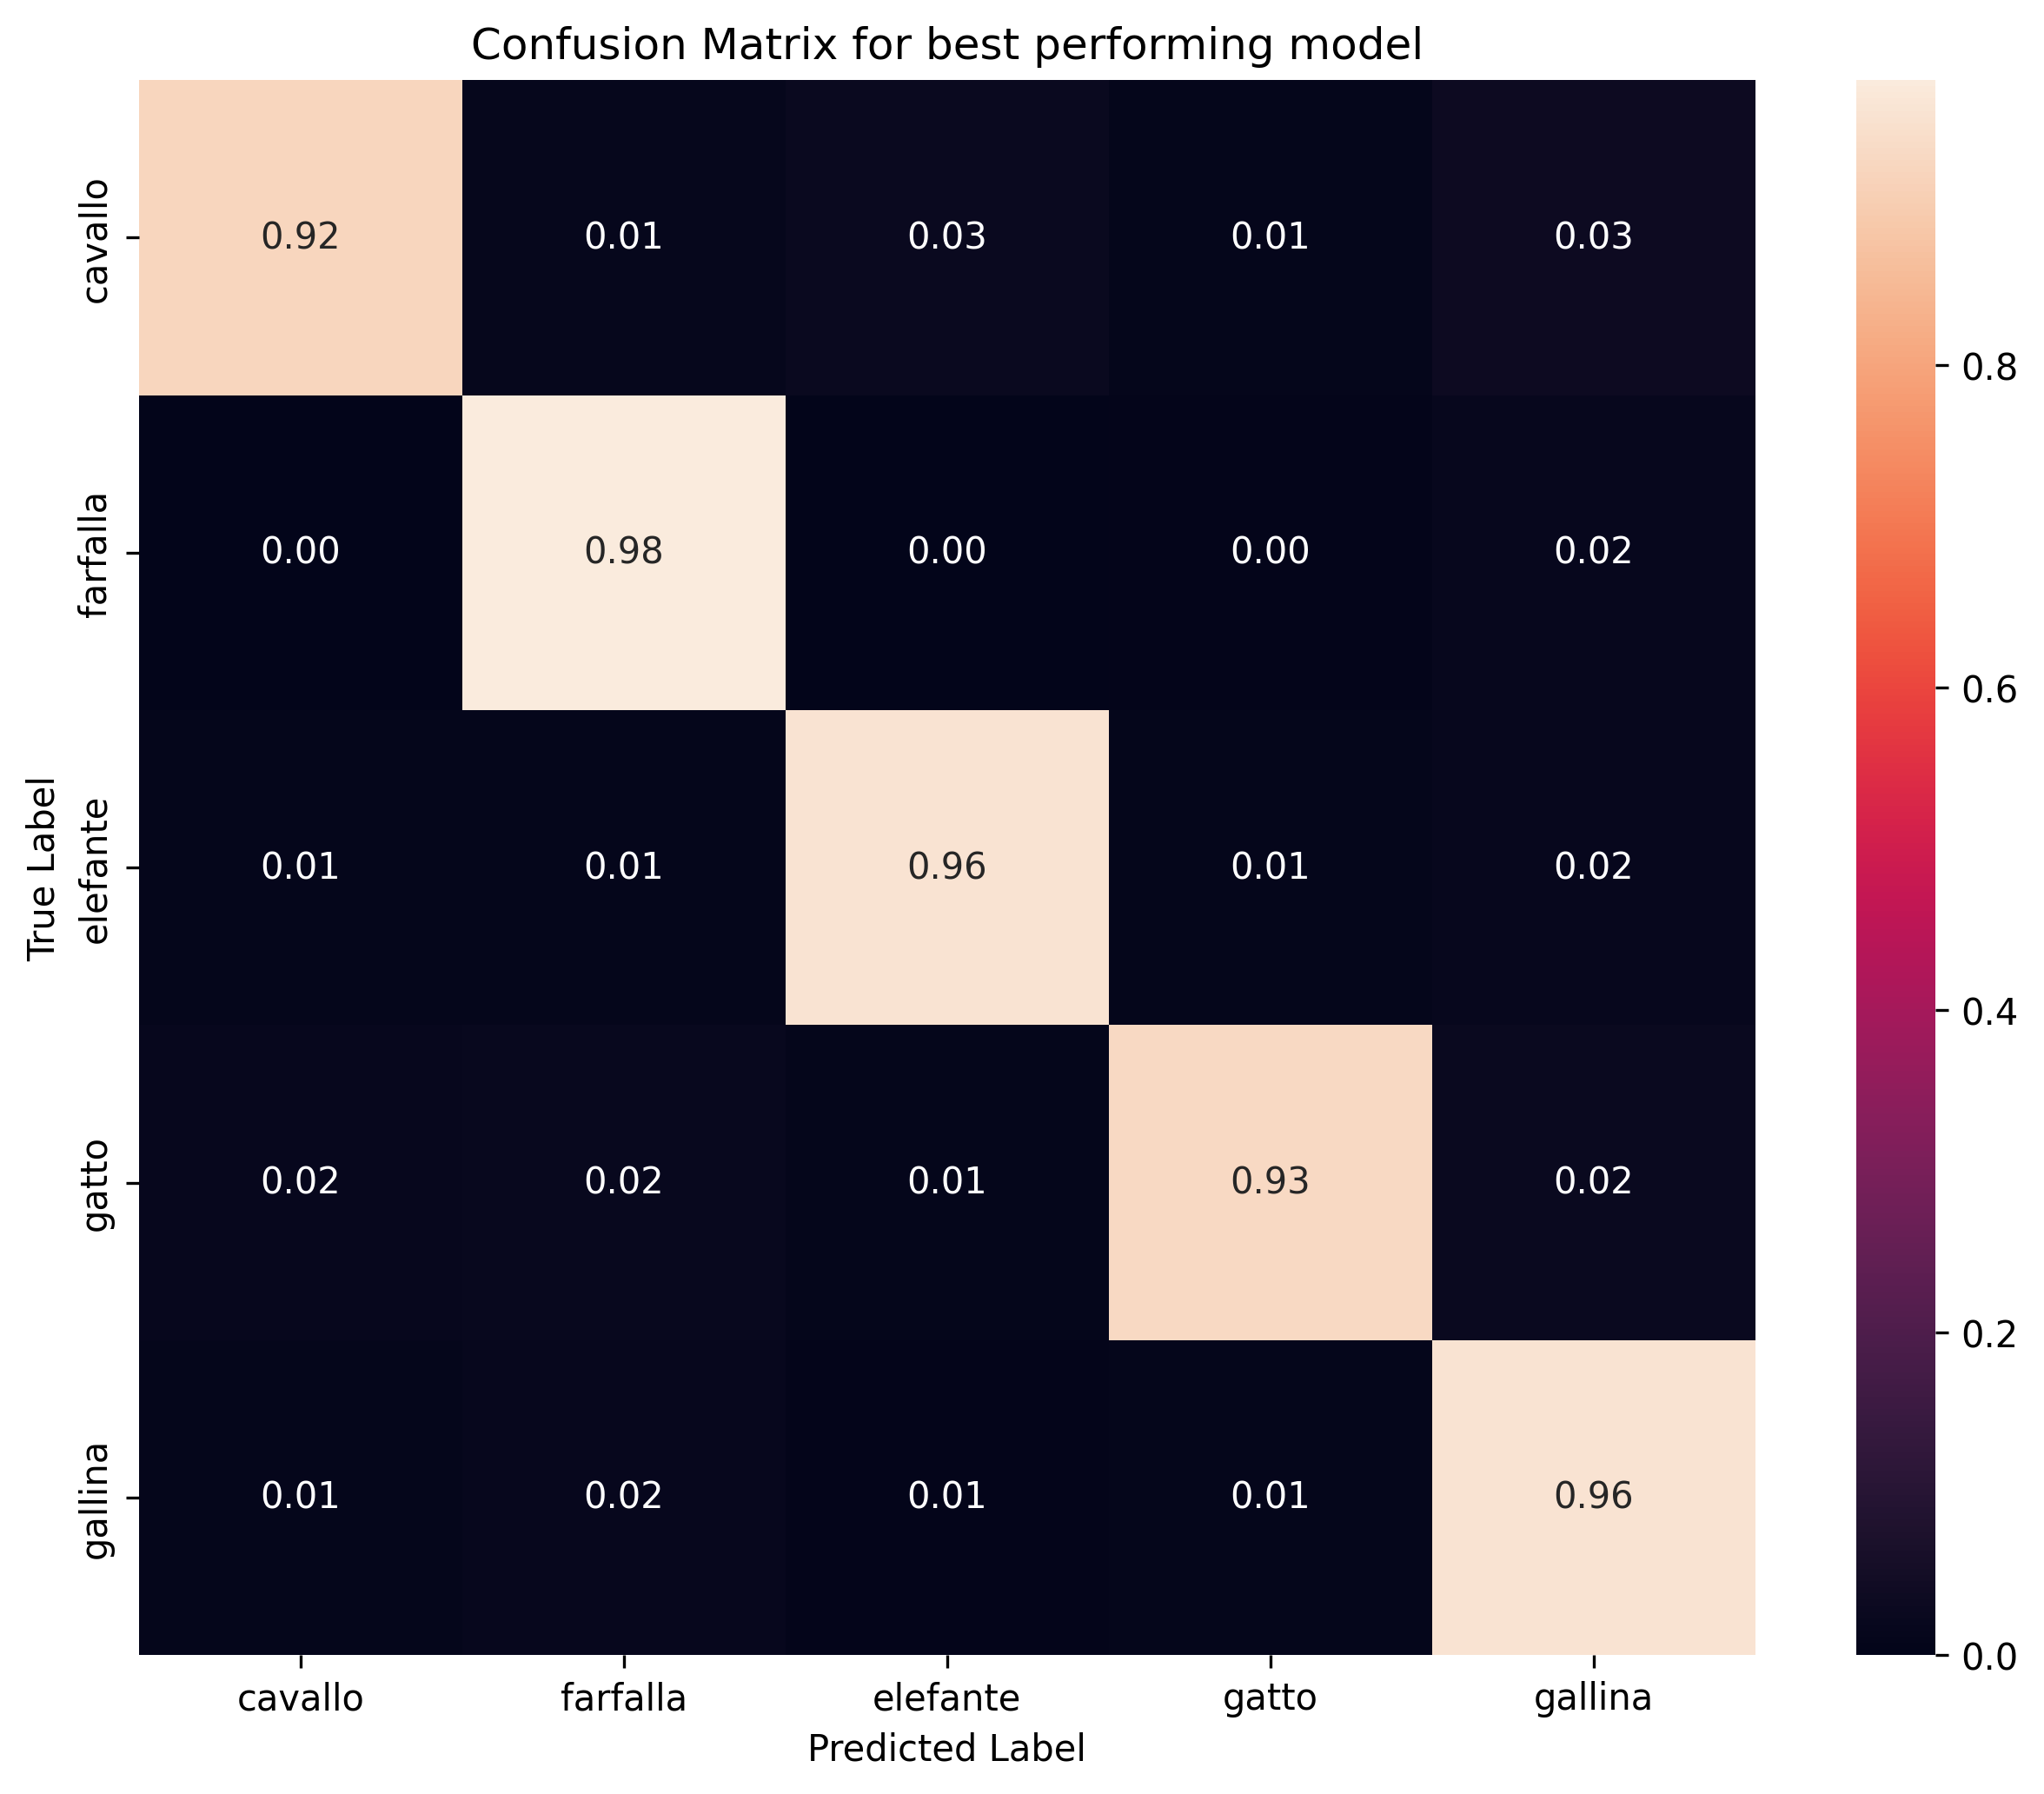

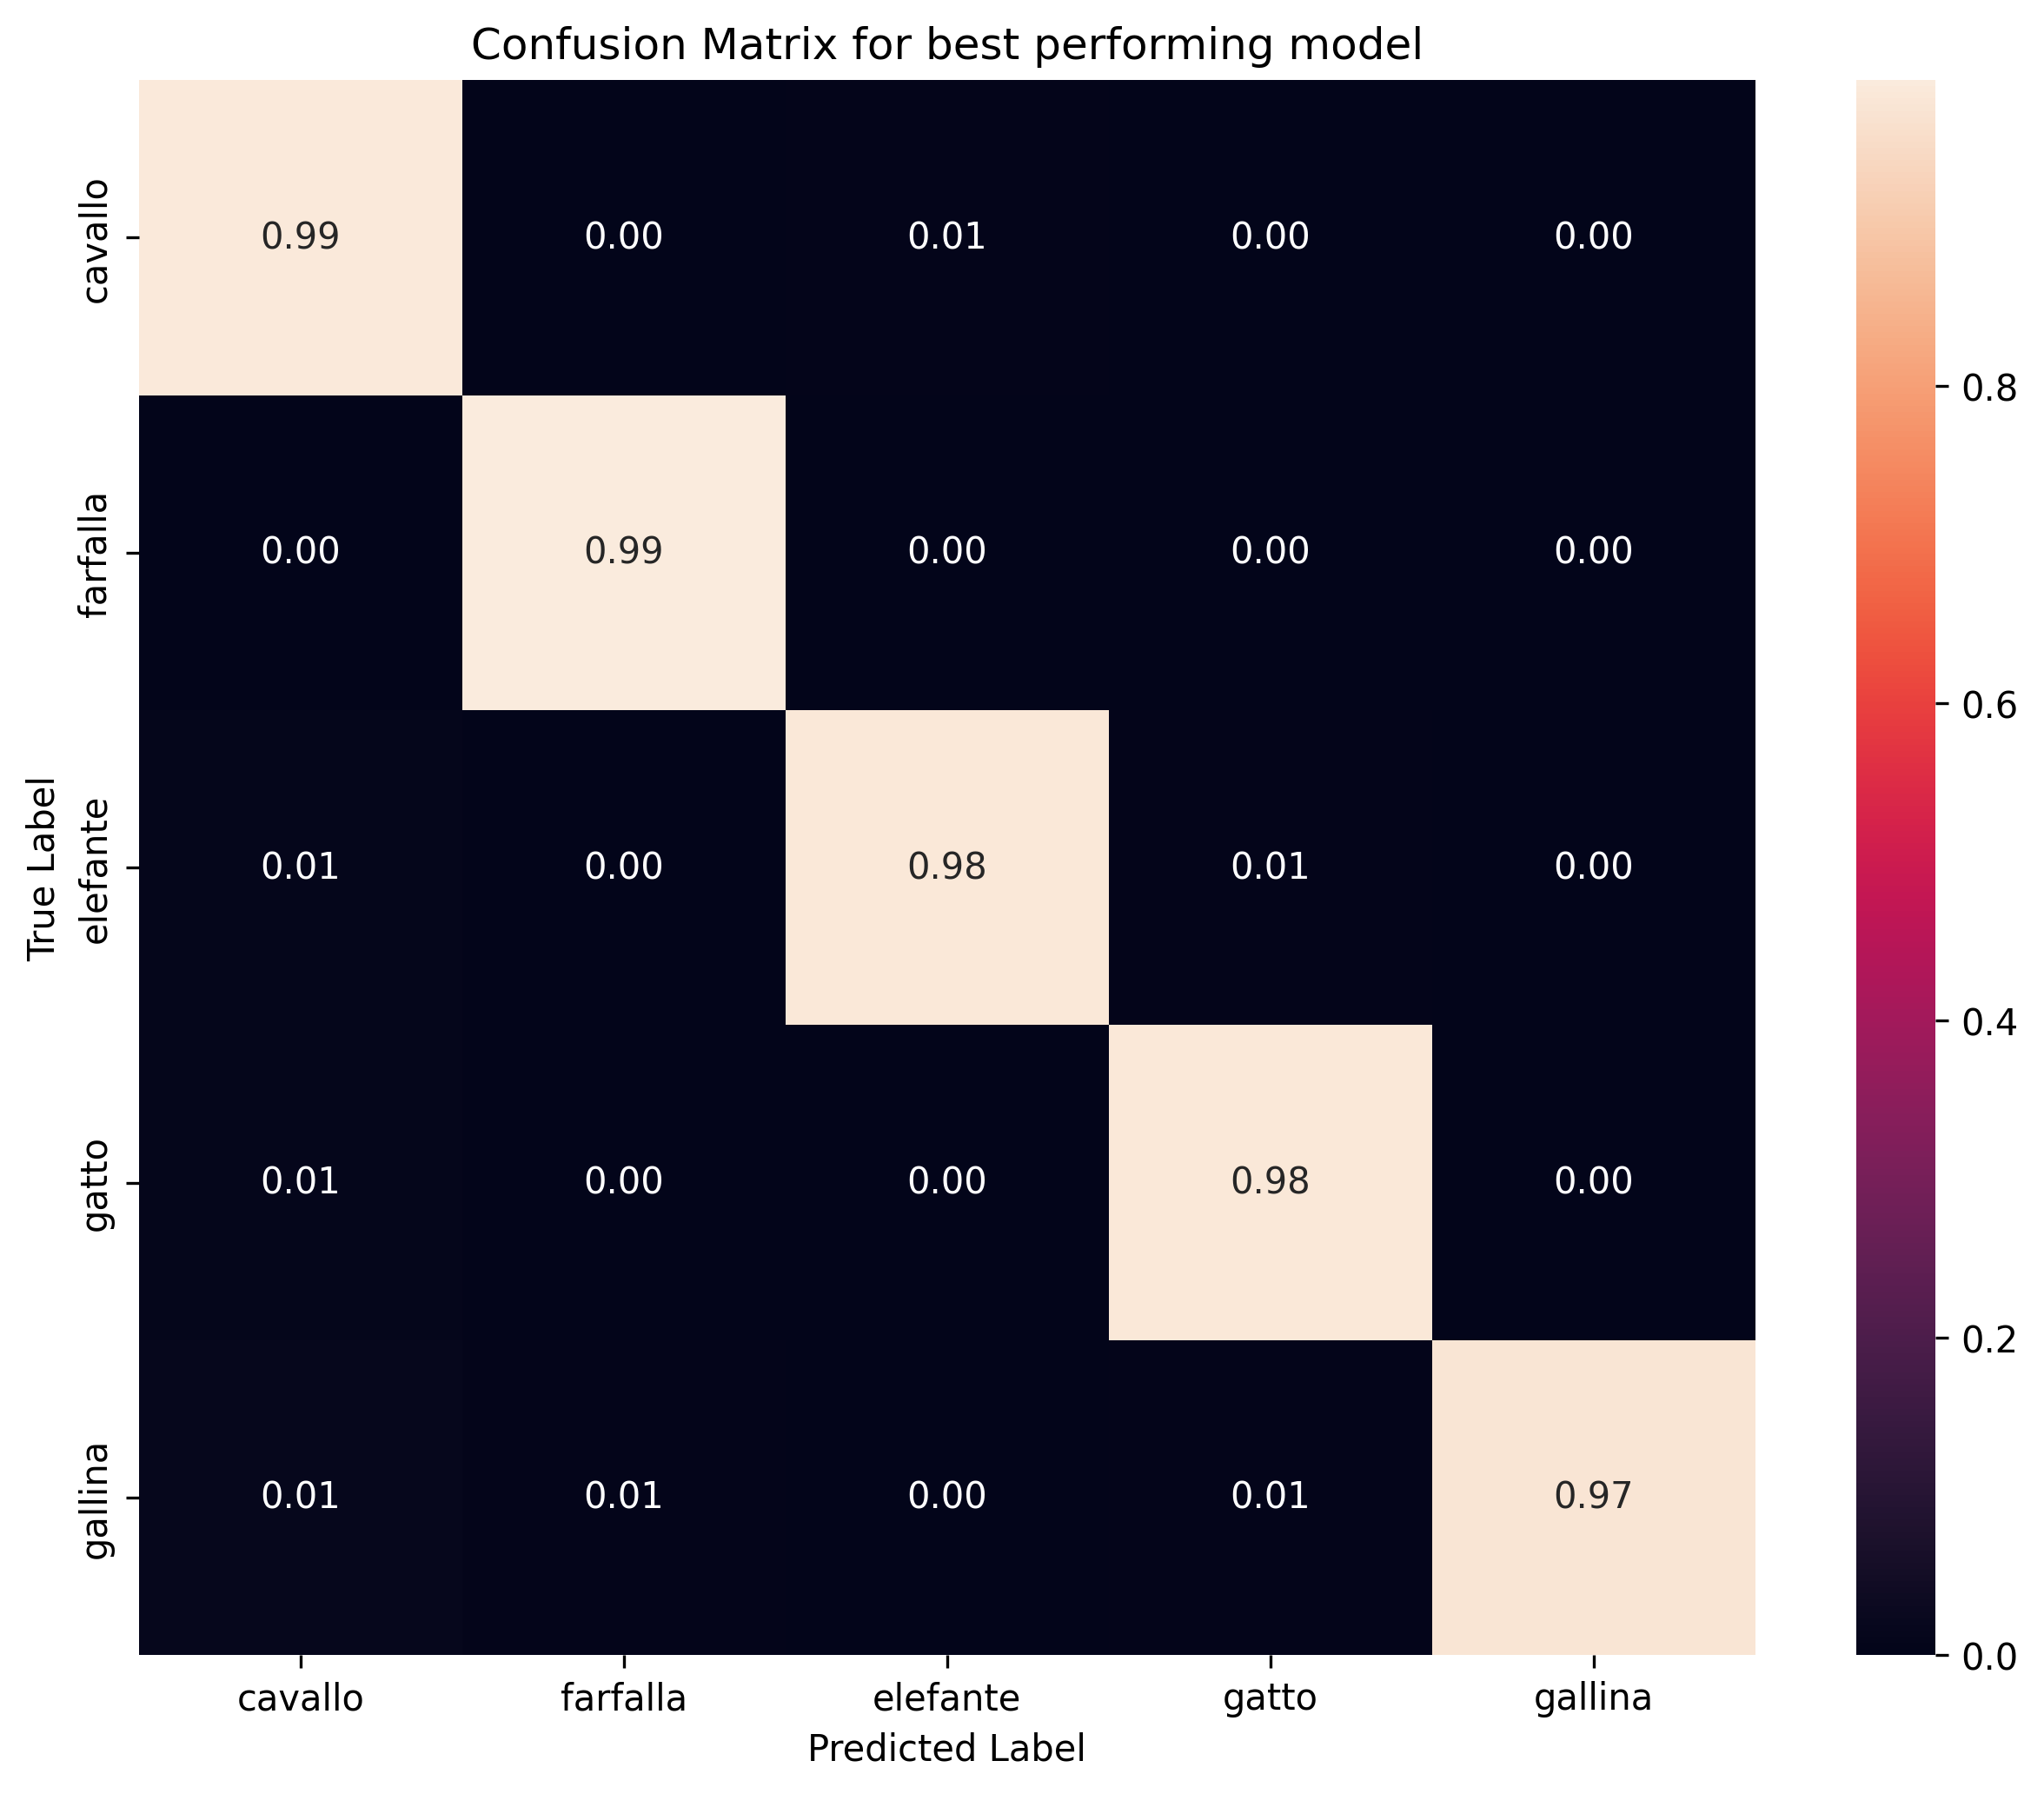

In [1]:
from utils import *
import glob
from dataset import AnimalDataset
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import torchvision.transforms as transforms
from models import GoogLeNet_transfer,VGG_transfer,CNN

input_size = 224
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

classes = ['cavallo', 'farfalla', 'elefante', 'gatto', 'gallina']

NUM_CLASSES = len(classes)

class_mapping = dict(zip(classes, range(len(classes))))

image_files = []
labels = []

for i in classes:
    image_files.extend(glob.glob('data/resized_animal_10/' + i + '/*'))
    labels.extend([class_mapping[i]] *
                  len(glob.glob('data/resized_animal_10/' + i + '/*')))


images_train, images_val, labels_train, labels_val = train_test_split(
    image_files, labels, train_size=0.8, stratify=labels)


data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
criterion = nn.CrossEntropyLoss()

train_animal_dataset = AnimalDataset(
    images_train, labels_train, transforms=data_transforms["train"])

test_animal_dataset = AnimalDataset(
    images_train, labels_train, transforms=data_transforms["val"])


hidden_dim_1 = [512]  
hidden_dim_2 = [2048]
batch_sizes = [64]
lrs = [3e-4]

delta_loss = []
ada_delta_loss = []
adam_loss = []


for BATCH_SIZE in batch_sizes:
    for hid_dim1 in hidden_dim_1:
        for hid_dim2 in hidden_dim_2:
            for lr in lrs:
                train_dataloader = DataLoader(train_animal_dataset, batch_size=BATCH_SIZE,
                                pin_memory=True, shuffle=True,num_workers=10)

                test_dataloader = DataLoader(test_animal_dataset, batch_size=128,
                                pin_memory=True, shuffle=True,num_workers=10)



                model = GoogLeNet_transfer(5,hid_dim1,hid_dim2).to(device)
                
                optimizer = optim.Adam(model.parameters(), lr=lr)

                loss_adam,acc_adam,epoch_adam = train_model(optimizer,criterion,model,train_dataloader,test_dataloader,MAX_EPOCHS=1,device=device,save_name="googlenet")

                try:
                    print("\n \n Rule Adam",hid_dim1,hid_dim2,lr,loss_adam["val"][-1],acc_adam["val"][-1],len(acc_adam["val"]))
                except:
                    pass
                
                #plot_comparative(loss_delta,loss_ada_delta,loss_adam,epochs,lr,"train",loss_or_accuracy="loss")
                #plot_comparative(loss_delta,loss_ada_delta,loss_adam,epochs,lr,"val",loss_or_accuracy="loss")
    
                # plot_confusion_matrix(lr,"model_delta","train")
                # plot_confusion_matrix(lr,"model_ada_delta","train")
                plot_confusion_matrix(lr,"googlenet","train",train_dataloader,device,classes)
                plot_confusion_matrix(lr,"googlenet","test",test_dataloader,device,classes)

                
            

In [3]:
%load_ext autoreload
%autoreload 2

(3, 3, 224, 224)
(0, 3, 224, 224)
(3, 224, 224)
(4, 3, 224, 224)
(2, 3, 224, 224)
(0, 3, 224, 224)
(2, 3, 224, 224)
(2, 3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 3, 224, 224)
(5, 3, 224, 224)
(4, 3, 224, 224)
(3, 224, 224)
(3, 224, 224)


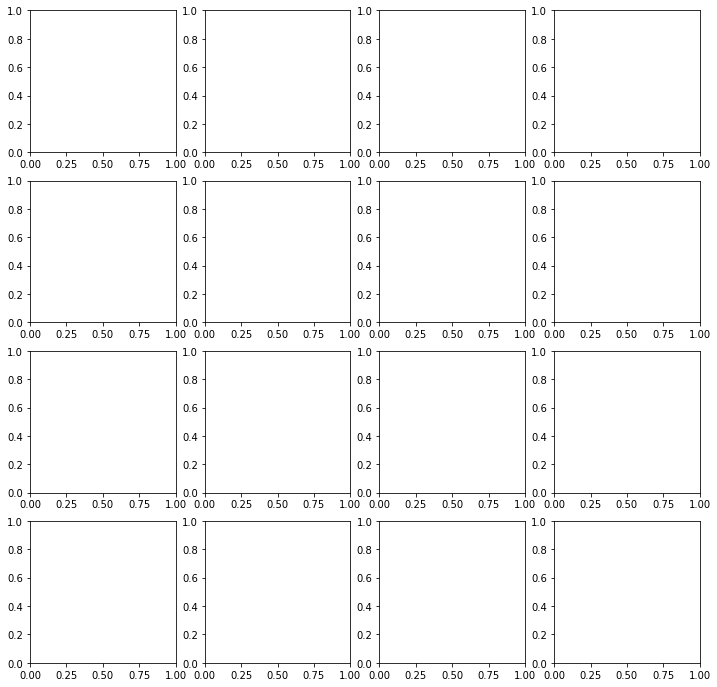

In [6]:
plot_misclassified_examples("googlenet",test_dataloader,device,classes)

In [ ]:
model = torch.load(f'weights/googlenet.pth', map_location=device)


In [22]:
model.eval()
incorrect_examples = []
incorrect_labels = []
incorrect_pred = []
inv_normalize = transforms.Normalize(
   mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
   std=[1/0.229, 1/0.224, 1/0.225]
)
with torch.no_grad():
    for X_test, y_test in test_dataloader:
        X_test = X_test.type(torch.float32).to(device)
        y_test = y_test.type(torch.long).to(device)
        score = model(X_test)
        X_test = inv_normalize(X_test)
        #score = score.squeeze(dim=1)
        pred = score.argmax(dim=1, keepdim=True) #pred will be a 2d tensor of shape [batch_size,1]
        for i in range(len(pred)):
            if(pred[i]!=y_test[i]): 
                imageio.imwrite(f"misclassified_examples/{classes[y_test[i].squeeze().cpu().numpy()]}_{classes[pred[i].squeeze().cpu().numpy()]}.jpg",np.moveaxis(X_test[i].squeeze().cpu().numpy(),0,-1))

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0